In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from PIL import Image
from pathlib import Path
from tqdm.notebook import trange, tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import copy
import cv2

In [2]:
# # TensorBoard
# from torch.utils.tensorboard import SummaryWriter
# import time
# writer  = SummaryWriter('runs/ranzcr_Dropout_0.5_{}{}{}'.format(time.localtime().tm_mday,
#                                               time.localtime().tm_hour,time.localtime().tm_min))
# # writer.add_image('test_image',img_grid)

In [3]:
# sgd
# args = {"initial_lr": 0.001, "momentum":0.9, "optimizer":"Adam", "step_size":7, "gamma":0.1,
#        "batch":128,"epochs":5, "workers":4, "network":"resnetManual"}

# adam
args = {"initial_lr": 0.001, "optimizer":"Adam", "weight_decay" :1e-4,
        "max_lr": 0.008,"batch":128,"epochs":28, "workers":4, "shape":128,"Dropout":0.5,
        "grad_clip": 1}


In [4]:
# !pip install clearml

# from clearml import Task
# from clearml import StorageManager

# task = Task.init(project_name='pytorch multilabel TransLear', 
#                  task_name='resnet_epochs30_lr_0.001_max_lr0.008_Dropout_0.5_d{}_h{}_m{}'.format(
# time.localtime().tm_mday,time.localtime().tm_hour,time.localtime().tm_min))
# logger = task.get_logger()

# task.connect(args)



In [5]:
data_dir = '../input/ranzcr-clip-catheter-line-classification/'
list_train = os.listdir(data_dir+"train/")
print(list_train[0])

1.2.826.0.1.3680043.8.498.10370758874574386468962321364924311754.jpg


In [6]:

train_csv = pd.read_csv(data_dir+"train.csv")
# train_csv.head()

In [7]:
train_csv.shape

(30083, 13)

In [8]:
sample_submission = pd.read_csv(data_dir+"sample_submission.csv")
sample_submission.columns

Index(['StudyInstanceUID', 'ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present'],
      dtype='object')

In [9]:
# Shuffle the data
np.random.seed(42)
#Create random indicies
inds = np.random.choice(train_csv.shape[0], train_csv.shape[0], replace=False)
train_csv = train_csv.iloc[inds]
train_csv.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
9248,1.2.826.0.1.3680043.8.498.12943387433514916343...,0,0,1,0,0,1,0,0,0,1,0,618a4d87d
6951,1.2.826.0.1.3680043.8.498.33262688370291221296...,0,0,1,0,0,0,1,0,0,0,0,ccf35660e
24788,1.2.826.0.1.3680043.8.498.50707597131827274810...,0,0,1,0,0,0,0,0,0,1,0,d020d1754
22112,1.2.826.0.1.3680043.8.498.97912763057483312503...,0,0,0,0,0,0,0,0,1,0,0,c14779246
8354,1.2.826.0.1.3680043.8.498.11196499436623357270...,0,0,0,0,0,0,0,0,0,1,0,cefd8eae1


!!!!!!!!!!!!!! Train!!!!!!!!!!!!!!!!!!!!

In [10]:
# train_csv.shape
# train_csv = train_csv[0:1500]

In [11]:
#Create ImageDataset class
class ImageDataset_train(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['StudyInstanceUID']
        self.all_labels = np.array(self.csv.drop(['StudyInstanceUID', 'PatientID'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
#                 transforms.ToPILImage(),
                transforms.CenterCrop(2800),
                transforms.Resize((args['shape'], args['shape'])),
#                 transforms.RandomAffine(degrees=10),
#                 transforms.RandomHorizontalFlip(p=0.3),
#                 transforms.RandomCrop(size=32),
#                 transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
#                 transforms.RandomRotation(degrees=),
                transforms.ToTensor(),
                transforms.Normalize(*stats)
            ])
            
            # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
#             self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.image_names = list(self.all_image_names[-self.valid_ratio:])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
#                 transforms.ToPILImage(),
                transforms.CenterCrop(2800),
                transforms.Resize((args['shape'], args['shape'])),
                transforms.ToTensor(),
                transforms.Normalize(*stats)
                ])
            
            
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = Image.open(f"../input/ranzcr-clip-catheter-line-classification/train/{self.image_names[index]}.jpg")  
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }
            

In [12]:
for i in range(2):
    image = Image.open(f"../input/ranzcr-clip-catheter-line-classification/train/"+list_train[i]) 
    print(np.array(image).shape)
    print(image)


(2500, 2048)
<PIL.JpegImagePlugin.JpegImageFile image mode=L size=2048x2500 at 0x7F4071DF2290>
(2544, 3056)
<PIL.JpegImagePlugin.JpegImageFile image mode=L size=3056x2544 at 0x7F4071BAED50>


In [13]:
# Create Test dataset
class ImageDataset_test(Dataset):

    def __init__(self, root, image_dir, transform=None):
        self.root = root
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_name = os.path.join(self.image_dir, self.image_files[index])  
        image = Image.open(image_name)
        #label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image


In [14]:
stats = (0.4454318881034851, 0.25035765767097473)

### Test dataset 

In [15]:
root = data_dir
image_dir = root+'test/'
transform_img = transforms.Compose([ 
#     transforms.ToPILImage(),
                                    transforms.CenterCrop(2800),
                                    transforms.Resize((args['shape'], args['shape'])),
                                    transforms.ToTensor(),
                                    transforms.Normalize(*stats)
])


In [16]:
test_ds = ImageDataset_test(root,image_dir, transform = transform_img)

In [17]:
test_loader = DataLoader(test_ds,1,shuffle=False,num_workers = args['workers'])

In [18]:
for i in test_loader:
    
    print(i)
    break

tensor([[[[-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          ...,
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792]]]])


 ### train dataset 

In [19]:
#train_ds
train_ds = ImageDataset_train(train_csv, train=True, test=False)


Number of training images: 25570


### validation dataset

In [20]:
#val_ds
val_ds = ImageDataset_train(train_csv, train=False, test=False)

Number of validation images: 4513


### Dataloader

In [21]:
batch_size = args['batch']

In [22]:
# train data loader
# train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
# validation data loader
# valid_loader = DataLoader(val_ds,batch_size=batch_size,shuffle=False)
# test data loader


In [23]:
train_ds[0]['image'].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1, 128, 128])

In [24]:
lab_name = sample_submission.columns.drop(['StudyInstanceUID'])


In [25]:
#plot an example

def show_example(dataset):
    print("labels: {}".format(dataset['label']))
    print(lab_name[dataset['label']==1])
    plt.imshow(dataset['image'].squeeze())
    plt.show
      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])
['CVC - Borderline' 'CVC - Normal' 'Swan Ganz Catheter Present']


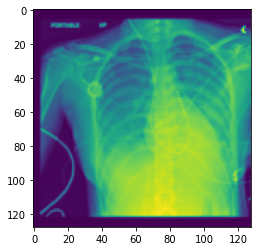

In [26]:
show_example(train_ds[15])

In [27]:
# means = []
# stds = []
# for img in tqdm(train_ds):
#     means.append(torch.mean(img['image']))
#     stds.append(torch.std(img['image']))
    
    

In [28]:
# mean = torch.mean(torch.tensor(means))
# std = torch.mean(torch.tensor(stds))
# stats = mean.item(), std.item()
# stats

In [29]:
#Create dictinary with train and val
image_datasets = {'train':train_ds, 'val':val_ds}
#batch_size
batch = batch_size
#Create dictionary with train dataloader and val dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch, shuffle=True,num_workers = 4) 
               for x in ['train', 'val']}
#Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#label names
class_names = lab_name


In [30]:
len(dataloaders['train'])

200

In [31]:
for i in dataloaders['train']:
    print(i['image'].shape)
    
#     print(label['label'])
    break

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

torch.Size([128, 1, 128, 128])


In [32]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images in tqdm(dl, desc = "Progress"):
        fig, ax = plt.subplots(figsize = (22,18))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images['image'],10).permute(1,2,0))
        break



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

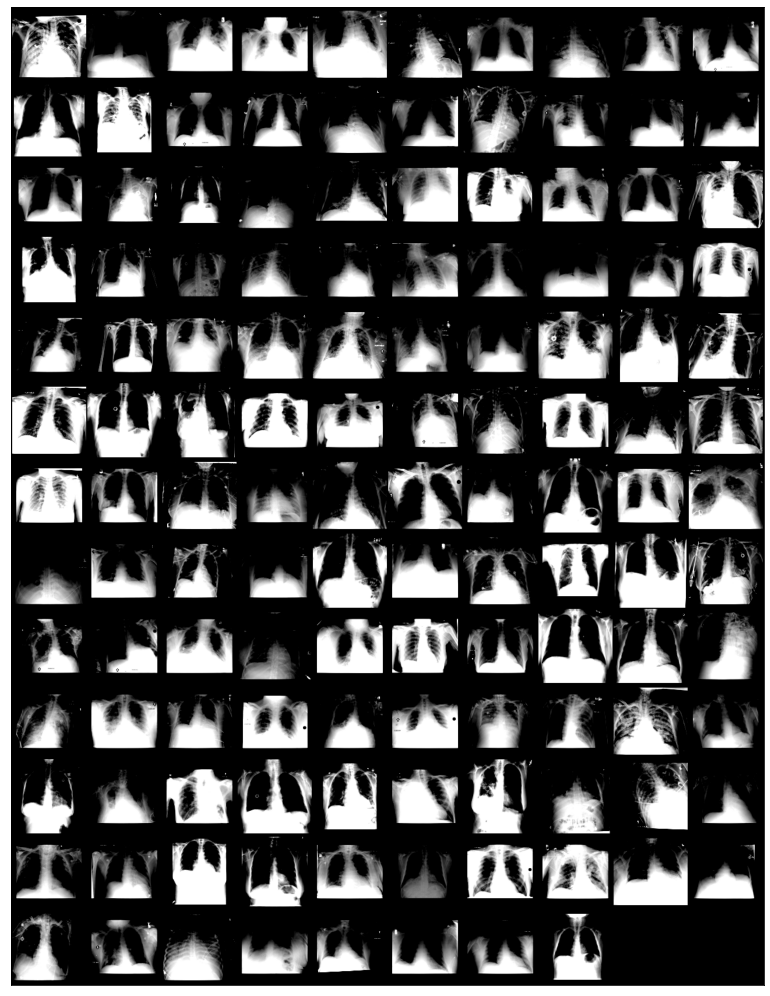

In [33]:
show_batch(dataloaders['train'])


In [34]:
import time
import copy

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
for i in dataloaders['train']:
    print(i['image'])
    print(i['label'])
    break

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

tensor([[[[-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          ...,
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792]]],


        [[[-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          ...,
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792],
          [-1.7792, -1.7792, -1.7792,  ..., -1.7792, -1.7792, -1.7792]]],


        [[[-1.7479, -1.7322, -1.7322,  ..., -1.7792, -1.7792, -1.7792],
          [-1.6852, -1.685

In [37]:


def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25, grad_clip=None):

   
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i in dataloaders[phase]:
                inputs = i["image"].to(device)
                labels = i["label"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # apply sigmoid activation to get all the outputs between 0 and 1
                    outputs = torch.sigmoid(outputs)
                    loss = criterion(outputs, labels)
                    
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        #Gradiend clipping
                        if grad_clip:
                            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(outputs == labels.data)
            if phase == 'train':
                
                if scheduler:
                    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            
            
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} '.format(phase, epoch_loss))
                
#             writer.add_scalar('epoch_loss',epoch_loss, epoch)  
#             logger.report_scalar(title = phase, series='epoch_loss',iteration = epoch, value = epoch_loss)
#             logger.report_scalar(title =phase, series='epoch_acc',iteration = epoch, value = epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(phase)
                best_loss = epoch_loss
                
#                 print("best_acc_val:" , best_loss)
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [38]:
# Conv block function
def conv_block(in_channels, out_channels, pool = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace = True)]
    
    if pool: layers.append(nn.MaxPool2d(2))
   
   
    return nn.Sequential(*layers) #asterki gia na parei olo to dictionary



In [39]:
# Resnet 
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()  # 1*128*128 = 16384
        self.conv1 = conv_block(in_channels, 64)  #128
        self.conv2 = conv_block(64,128,pool=True) # 64
        self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))
        self.conv3 = conv_block(128,128,pool=True) #32
        self.conv4 = conv_block(128,256,pool=True)# 16
        self.res2 = nn.Sequential(conv_block(256,256),conv_block(256,256))
        self.conv5 = conv_block(256,512,pool=True) # 8
        self.conv6 = conv_block(512,512,pool=True) # 4
        self.res3 = nn.Sequential(conv_block(512,512),conv_block(512,512))
#         self.conv7 = conv_block(256,512,pool=True) # 8
#         self.conv8 = conv_block(512,512,pool=True) # 4
#         self.res4 = nn.Sequential(conv_block(512,512),conv_block(512,512))
#         self.conv9 = conv_block(512,512,pool=True) # 2
#         self.conv10 = conv_block(512,512,pool=True) # 1
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                
                                        nn.Flatten(),
                                        nn.Dropout(args['Dropout']),
                                        nn.Linear(512,num_classes)
        )
                                            
                                       
        
    def forward(self,xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out) 
        out = self.conv6(out)
        out = self.res3(out) + out
#         out = self.conv7(out)
#         out = self.conv8(out)
#         out = self.res4(out) + out
#         out = self.conv9(out)
#         out = self.conv10(out)
        out = self.classifier(out)
        
        return out
    

In [40]:
model_ft = ResNet(1,11)
model_ft

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [41]:
## Pretrained
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model_ft.fc = nn.Linear(num_ftrs, 11)


model_ft = model_ft.to(device)

criterion = nn.BCELoss() #binary cross entropy loss
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), 
                                lr=args['initial_lr'], 
                                weight_decay = args['weight_decay'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer_ft,
                                           max_lr = args['max_lr'],
                                           epochs = args['epochs'],
                                           steps_per_epoch = len(dataloaders['train']),
                                           verbose =True)


Adjusting learning rate of group 0 to 3.2000e-04.


In [42]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=args['epochs'], grad_clip = args['grad_clip'])


Epoch 0/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2001e-04.
train Loss: 0.3237 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2728 
val

Epoch 1/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2003e-04.
train Loss: 0.2742 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2612 
val

Epoch 2/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2006e-04.
train Loss: 0.2618 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2490 
val

Epoch 3/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2011e-04.
train Loss: 0.2483 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2446 
val

Epoch 4/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2017e-04.
train Loss: 0.2379 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2344 
val

Epoch 5/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2024e-04.
train Loss: 0.2313 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2301 
val

Epoch 6/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2033e-04.
train Loss: 0.2278 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2429 

Epoch 7/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2043e-04.
train Loss: 0.2250 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2235 
val

Epoch 8/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2054e-04.
train Loss: 0.2216 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2194 
val

Epoch 9/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2067e-04.
train Loss: 0.2176 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2167 
val

Epoch 10/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2081e-04.
train Loss: 0.2148 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2264 

Epoch 11/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2097e-04.
train Loss: 0.2120 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2171 

Epoch 12/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2114e-04.
train Loss: 0.2079 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2206 

Epoch 13/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2132e-04.
train Loss: 0.2045 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2455 

Epoch 14/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2151e-04.
train Loss: 0.2006 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2192 

Epoch 15/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2172e-04.
train Loss: 0.1951 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2707 

Epoch 16/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2194e-04.
train Loss: 0.1890 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2248 

Epoch 17/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2218e-04.
train Loss: 0.1809 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2426 

Epoch 18/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2243e-04.
train Loss: 0.1721 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2301 

Epoch 19/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2269e-04.
train Loss: 0.1585 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.3142 

Epoch 20/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2296e-04.
train Loss: 0.1446 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.2503 

Epoch 21/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2325e-04.
train Loss: 0.1265 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.3111 

Epoch 22/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2356e-04.
train Loss: 0.1107 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.5233 

Epoch 23/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2387e-04.
train Loss: 0.0936 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.3252 

Epoch 24/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2420e-04.
train Loss: 0.0813 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.5133 

Epoch 25/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2454e-04.
train Loss: 0.0642 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.7308 

Epoch 26/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2490e-04.
train Loss: 0.0539 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.7488 

Epoch 27/27
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Adjusting learning rate of group 0 to 3.2527e-04.
train Loss: 0.0449 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val Loss: 0.5272 


Training complete in 472m 33s
Best val loss: 0.216653


In [43]:
# torch.save(model_ft, "model_ft_manualResnet11.pth")

In [44]:
# # Model class must be defined somewhere
# model_ft = torch.load("../input/ranzcr-clip-catheter-line-classification/model_ft.pth")
# # model1.eval()

### Test DataSet

In [45]:
model_ft.to(device)
model_ft.eval()

StudyInstanceUID = pd.DataFrame({"StudyInstanceUID":os.listdir(root+'test')})
# print(StudyInstanceUID)

submission = pd.DataFrame()
for img in tqdm(test_loader):

    output = model_ft(img.to(device))

    output = torch.sigmoid(output)
    output = np.array(output.detach().cpu())
#     print(output)
    kouvas = pd.DataFrame(data = output)
    submission = pd.concat([submission, kouvas],axis = 0)
#     break

submission.head()    


,0,1,2,3,4,5,6,7,8,9,10
0,3.184112e-05,0.000088,0.000407,0.001064,0.004202,0.001110,0.015801,0.077258,0.228783,0.713649,0.000116
0,2.013876e-03,0.013056,0.136980,0.017678,0.015521,0.239400,0.053974,0.116573,0.273137,0.680609,0.001435
0,3.634390e-08,0.000012,0.001587,0.000163,0.001282,0.000074,0.004442,0.024563,0.131305,0.821727,0.000002
0,2.419911e-04,0.000308,0.000685,0.002253,0.001462,0.016933,0.004737,0.108685,0.251448,0.683657,0.000368
0,1.755010e-03,0.031670,0.839309,0.021720,0.032011,0.437708,0.142503,0.079158,0.260710,0.753607,0.002526


In [46]:
#Restet index in submission
submission = submission.reset_index(drop=True)
# submission.index
submission = pd.concat([StudyInstanceUID,submission],axis=1)
submission['StudyInstanceUID']=submission['StudyInstanceUID'].str.replace(".jpg","")


In [47]:
submission.columns = sample_submission.columns

In [48]:
submission.to_csv("submission.csv",index=False)

In [49]:
submission

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.24641136930096467169...,3.184112e-05,0.000088,0.000407,0.001064,0.004202,0.001110,0.015801,0.077258,0.228783,0.713649,0.000116
1,1.2.826.0.1.3680043.8.498.12690617441924311870...,2.013876e-03,0.013056,0.136980,0.017678,0.015521,0.239400,0.053974,0.116573,0.273137,0.680609,0.001435
2,1.2.826.0.1.3680043.8.498.12475334287210977140...,3.634390e-08,0.000012,0.001587,0.000163,0.001282,0.000074,0.004442,0.024563,0.131305,0.821727,0.000002
3,1.2.826.0.1.3680043.8.498.55782720675326550262...,2.419911e-04,0.000308,0.000685,0.002253,0.001462,0.016933,0.004737,0.108685,0.251448,0.683657,0.000368
4,1.2.826.0.1.3680043.8.498.31365479801404007311...,1.755010e-03,0.031670,0.839309,0.021720,0.032011,0.437708,0.142503,0.079158,0.260710,0.753607,0.002526
...,...,...,...,...,...,...,...,...,...,...,...,...
3577,1.2.826.0.1.3680043.8.498.89961599659958385675...,6.008595e-03,0.016504,0.029263,0.010291,0.014811,0.055617,0.097919,0.181035,0.364565,0.582273,0.003693
3578,1.2.826.0.1.3680043.8.498.11673190160624493838...,6.236115e-03,0.034671,0.177390,0.016349,0.024709,0.225951,0.183633,0.139736,0.359102,0.685465,0.016947
3579,1.2.826.0.1.3680043.8.498.45328973576971281558...,3.301550e-05,0.000053,0.000152,0.000878,0.001786,0.002586,0.004650,0.043196,0.121545,0.842581,0.000038
3580,1.2.826.0.1.3680043.8.498.12395495974937225416...,7.038480e-04,0.011770,0.895401,0.012511,0.010818,0.542108,0.049012,0.052086,0.261132,0.812884,0.005410
